In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [40]:
df = pd.read_csv('../Data/BTCUSD-all.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [41]:
ad_fuller_result = adfuller(df['Close'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -1.4043733391893507
p-value: 0.5801776981234488


In [42]:
eps_diff = np.diff(df['Close'], n=1)

ad_fuller_result = adfuller(eps_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -9.705401399290935
p-value: 1.0451734659614135e-16


In [43]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [44]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 1

order_list = list(product(ps, qs))

In [45]:
splits=int(len(df['Close'])*0.7)
train = df[:splits]
test=df[splits:]

result_df = optimize_ARIMA(train['Close'], order_list, d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(2, 3)",35299.748968
1,"(3, 3)",35308.964229
2,"(2, 2)",35372.937256
3,"(3, 2)",35379.161951
4,"(3, 1)",35385.845555
5,"(1, 1)",35387.671443
6,"(1, 3)",35387.886575
7,"(2, 1)",35389.348919
8,"(1, 2)",35389.518070
9,"(0, 3)",35389.771829


In [47]:
model = SARIMAX(train['Close'], order=(2,1,3), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2353
Model:               SARIMAX(2, 1, 3)   Log Likelihood              -17643.874
Date:                Mon, 15 Jan 2024   AIC                          35299.749
Time:                        10:45:15   BIC                          35334.327
Sample:                             0   HQIC                         35312.341
                               - 2353                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2339      0.007   -174.846      0.000      -1.248      -1.220
ar.L2         -0.9935      0.008   -131.188      0.000      -1.008      -0.979
ma.L1          1.3163      0.009    140.847      0.0

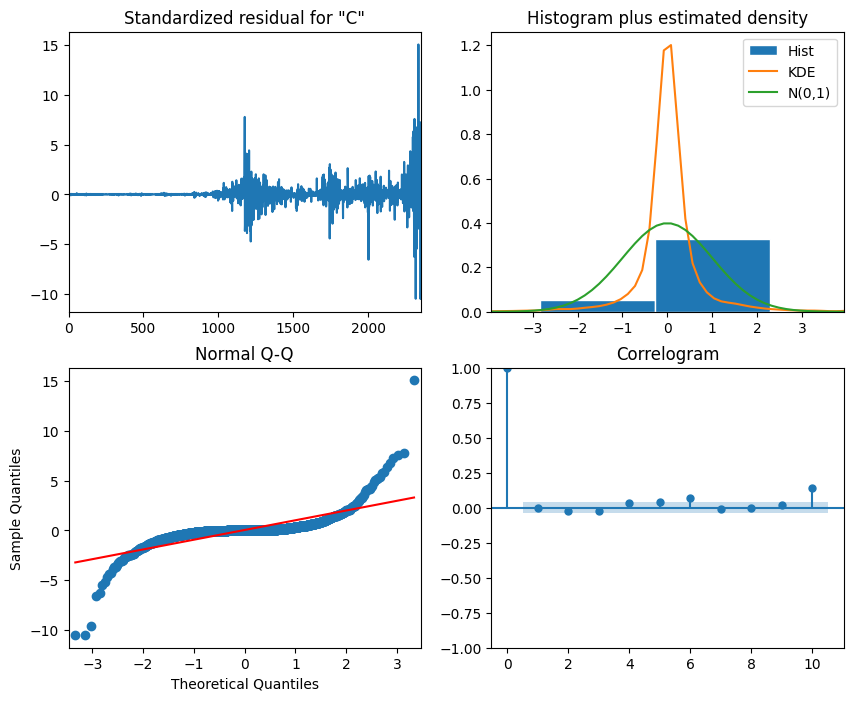

In [49]:
model_fit.plot_diagnostics(figsize=(10,8));

# plt.savefig('figures/CH07_F07_peixeiro.png', dpi=300)

In [50]:
ARIMA_pred = model_fit.get_prediction(len(train), len(train)+len(test)-1).predicted_mean
len(ARIMA_pred)
test['ARIMA_pred'] = ARIMA_pred
test

,Date,Open,High,Low,Close,Adj Close,Volume,ARIMA_pred
2353,2021-02-25,49709.082031,51948.968750,47093.851562,47093.851562,47093.851562,54506565949,50630.108502
2354,2021-02-26,47180.464844,48370.785156,44454.843750,46339.761719,46339.761719,350967941479,49735.547998
2355,2021-02-27,46344.773438,48253.269531,45269.027344,46188.453125,46188.453125,45910946382,50102.091366
2356,2021-02-28,46194.015625,46716.429688,43241.617188,45137.769531,45137.769531,53443887451,50538.549578
2357,2021-03-01,45159.503906,49784.015625,45115.093750,49631.242188,49631.242188,53891300112,49635.821756
...,...,...,...,...,...,...,...,...
3357,2023-11-26,37796.828125,37820.300781,37162.750000,37479.121094,37479.121094,13744796068,50116.525630
3358,2023-11-27,37454.191406,37559.355469,36750.128906,37254.167969,37254.167969,19002925720,50143.400947
3359,2023-11-28,37247.992188,38368.480469,36891.089844,37831.085938,37831.085938,21696137014,50109.072094
3360,2023-11-29,37826.105469,38366.113281,37612.632812,37858.492188,37858.492188,20728546658,50124.731134


In [51]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [52]:
mape_ARIMA = mape(test['Close'], test['ARIMA_pred'])
print(mape_ARIMA)

70.91025176053958
